In [16]:
import pandas as pd
import ast
import plotly.express as px
import matplotlib.pyplot as plt
from Bio import Align
import numpy as np
import matplotlib.colors as mcolors
import random

In [8]:
# Create a sample DataFrame
data = {
    'x': [1, 2, 3, 4, 5],
    'y': [10, 11, 12, 13, 14],
    'label': ['A', 'B', 'C', 'D', 'E']
}

df = pd.DataFrame(data)

# Create a scatter plot
fig = px.scatter(df, x='x', y='y', text='label', title="Interactive Plot")

# Show the plot
fig.show()


In [17]:
def compute_differences(sequence_1, sequence_2):
    """
    Compute the differences between two sequences by aligning the two sequences.
    :param sequence_1: first sequence.
    :param sequence_2: second sequence.
    :return: tuple with the two sequences in the first position and the positions of the differences in the second.
    """
    aligner = Align.PairwiseAligner(match_score=1.0, mode="global", mismatch_score=-2.0, gap_score=-2.5,
                                    query_left_extend_gap_score=0, query_internal_extend_gap_score=0,
                                    query_right_extend_gap_score=0, target_left_extend_gap_score=0,
                                    target_internal_extend_gap_score=0, target_right_extend_gap_score=0)

    alignments = aligner.align(sequence_1, sequence_2)
    align_array = np.array(alignments[0])
    value = align_array[0] == align_array[1]
    positions = np.where(value == False)
    return align_array, positions[0]


In [18]:
def get_differences(reference_protein, mutants_list, sequences_list):
    """
    Compute the differences between two sequences by aligning the two sequences.
    :param reference_protein: name of the reference protein.
    :param mutants_list: list of names of protein mutants.
    :param sequences_list: list of sequences.
    :return: DataFrame containing the mutant name, the alignment of the reference, the alignment of the mutant and the
    positions at which there is a difference in the alignments.
    """
    reference_index = mutants_list.index(reference_protein)
    reference_sequence = sequences_list[reference_index]

    comparison_results = []
    for i in range(len(mutants_list)):
        if mutants_list[i] == reference_protein:
            continue
        mutant = mutants_list[i]
        mutant_sequence = sequences_list[i]
        alignment, positions = compute_differences(reference_sequence, mutant_sequence)
        comparison_results.append({
            'Mutant Name': mutant,
            'Alignment Reference': ''.join([byte.decode('utf-8') for byte in alignment[0]]),
            'Alignment Mutant': ''.join([byte.decode('utf-8') for byte in alignment[1]]),
            'Positions': positions
        })

    return pd.DataFrame(comparison_results)



In [19]:
def find_ic50(df_merged, proteins, ligand):
    """
    Find IC50 values associated with the given protein list and ligands.
    :param df_merged: DataFrame with BindingDB information.
    :param proteins: list of proteins names.
    :param ligand: ligand smile.
    :return: Series containing IC50 values for each protein in the list and the given ligand.
    """
    return df_merged[(df_merged['Ligand SMILES'] == ligand) &
                     (df_merged['Target Name'].isin(proteins))].set_index('Target Name')['IC50 (nM)']


In [81]:
def plot_ic50_graph(df, wt_name):
    """
    Plot graph where the x-axis represents the amino acid sequence, and the y-axis represent the difference IC50 value
    :param df: DataFrame containing the columns Positions, Colours and Type
    """
    plt.figure(figsize=(8, 6))
    df['marker'] =df.Type.apply(lambda x: 'x' if x=='substitution' else 'o')
    seen_mutants = set()
    for _, row in df.iterrows():
        mutant = row['Mutant Name'].replace(wt_name, '')
        if mutant not in seen_mutants:
            plt.scatter(row['Positions'], row['IC50'], marker=row.marker, s=100, color=row['Colour'], alpha=0.75, label=mutant)
            seen_mutants.add(mutant)
        else:
            plt.scatter(row['Positions'], row['IC50'], marker= row.marker, s=100, color=row['Colour'], alpha=0.75)

    plt.xlabel('Amino Acid Position')
    plt.ylabel('Variation in IC50 Value')
    plt.title(f'Variation in IC50 Values by Amino Acid Position for mutants of {wt_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [49]:
def define_mutation(row):
    """
    Define for the given row, the type of mutation (gap or mutation) and if it is a substitution,
    the previous and current amino acids.
    :param row: row of a dataframe.
    :return: the first value is gap or mutation and the second value is the exact substitution that occurred.
    """
    if row['Alignment Mutant'][row['Positions']] == '-' or row['Alignment Reference'][row['Positions']] == '-':
        return 'gap', None
    else:
        return 'substitution', f"{row['Alignment Mutant'][row['Positions']]} -> {row['Alignment Reference'][row['Positions']]}"


In [69]:
def plot_mutants_graph(row, df_merged):
    """
    Plot IC50 graph for a specific row of the mutants dataframe.
    :param row: selected row of the mutants dataframe to plot.
    :param df_merged: DataFrame containing the BindingDB information.
    :returns: DataFrame used for plotting.
    """
    # Find ic50 values associated with the mutants and the reference protein
    ic50_df = find_ic50(df_merged, row['Target Names'], row['Ligand SMILES'])

    if not ic50_df.index.is_unique:
        print('For this ligand-protein pair there are multiple values of IC50 and we decided to drop this case.')
        return None

    reference_ic50 = ic50_df.loc[row['WT Target Name']]
    ic50_df = ic50_df - reference_ic50

    # Get position with differences
    differences = get_differences(row['WT Target Name'], row['Target Names'], row['BindingDB Target Chain Sequence'])

    # Set colours
    all_colors = list(mcolors.CSS4_COLORS.keys())
    differences['Colour'] = random.sample(all_colors, differences.shape[0])

    # Explode the DataFrame
    differences_explode = differences.explode('Positions').dropna()

    # Define the type of mutation for later visualization
    differences_explode[['Type', 'Mutation']] = differences_explode.apply(define_mutation, axis=1, result_type='expand')
    differences_explode = differences_explode.drop(['Alignment Reference', 'Alignment Mutant'], axis=1)

    # Add the corresponding variation of IC50 value
    differences_explode['IC50'] = differences_explode['Mutant Name'].map(ic50_df)

    # Plot the graph
    plot_ic50_graph(differences_explode, row['WT Target Name'])

    return differences_explode

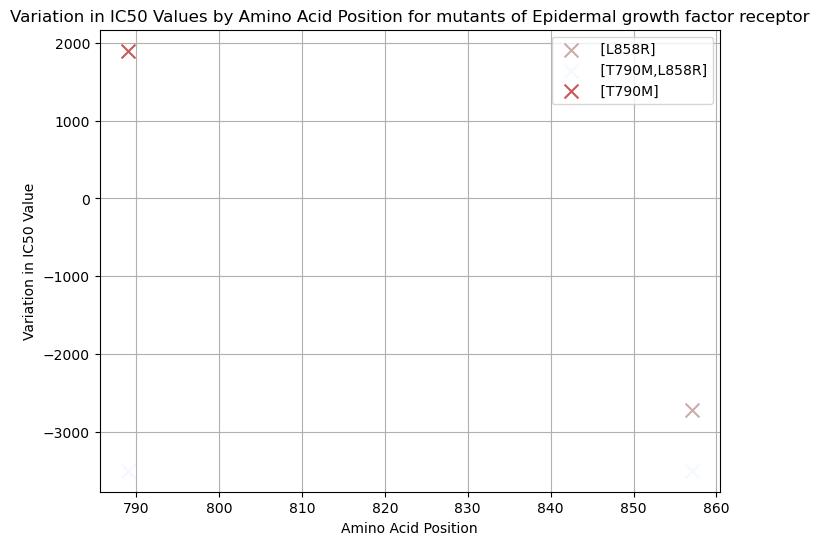

For this ligand-protein pair there are multiple values of IC50 and we decided to drop this case.
For this ligand-protein pair there are multiple values of IC50 and we decided to drop this case.


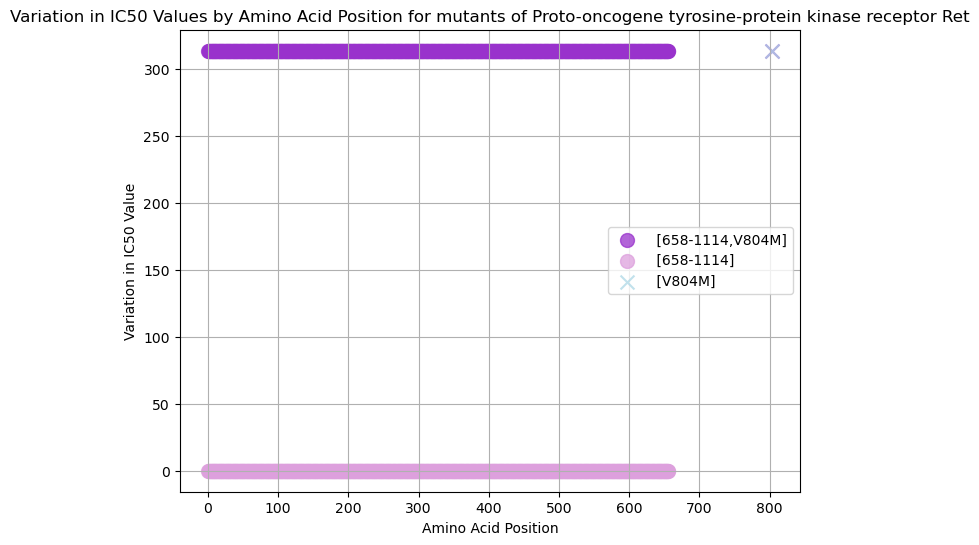

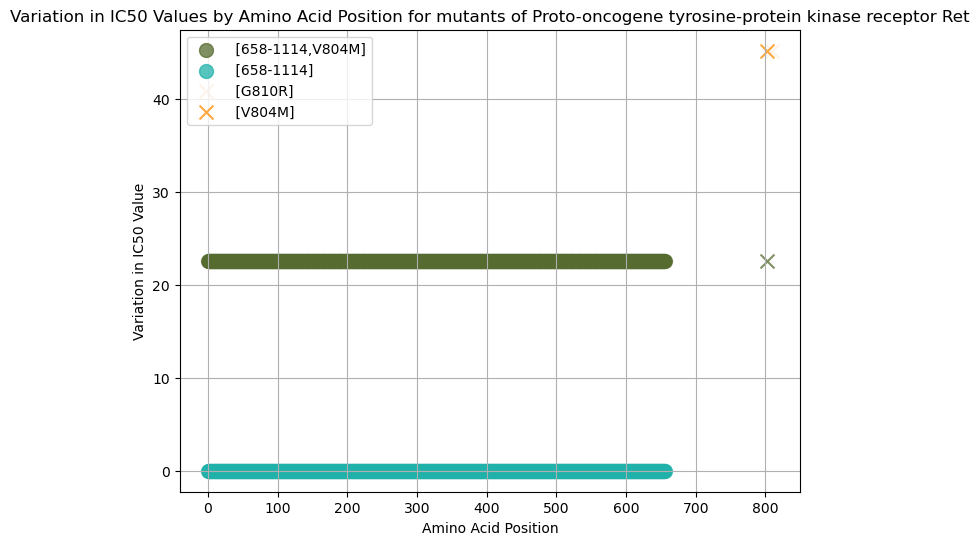

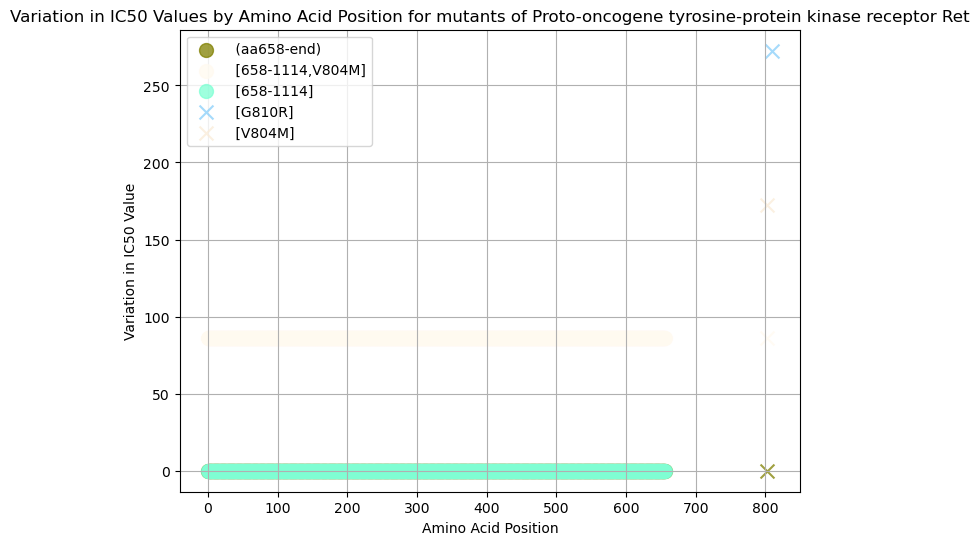

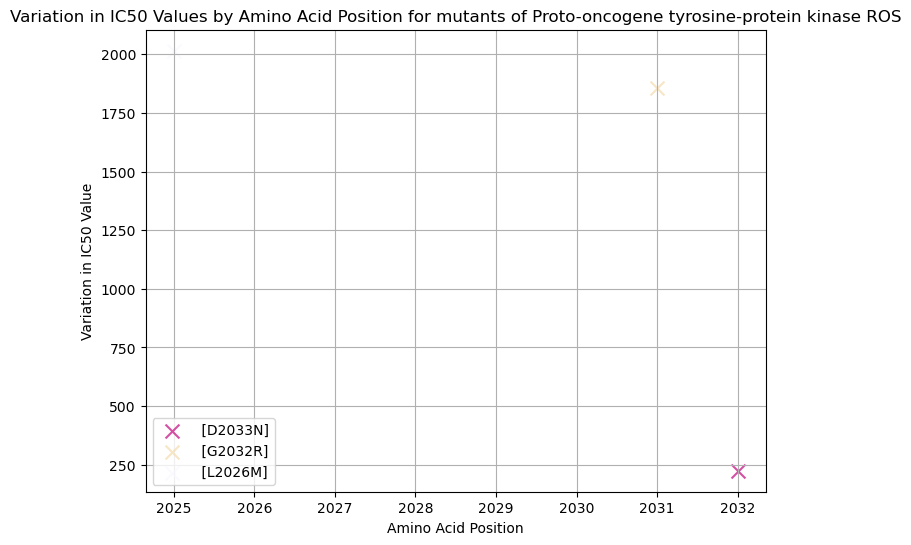

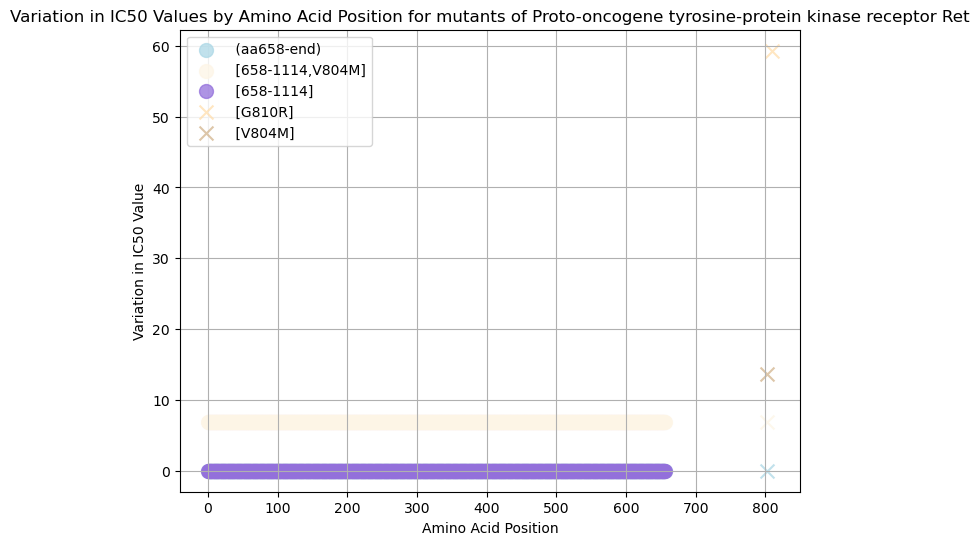

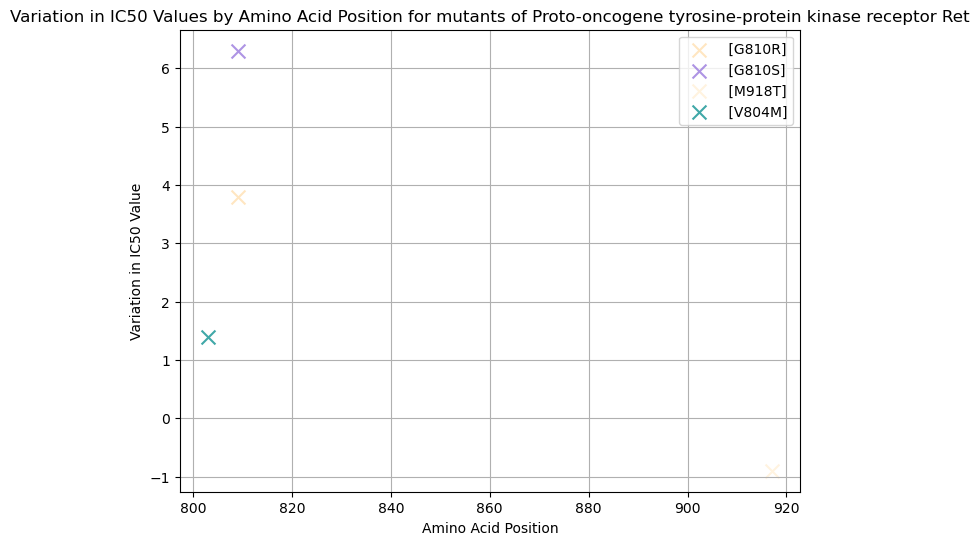

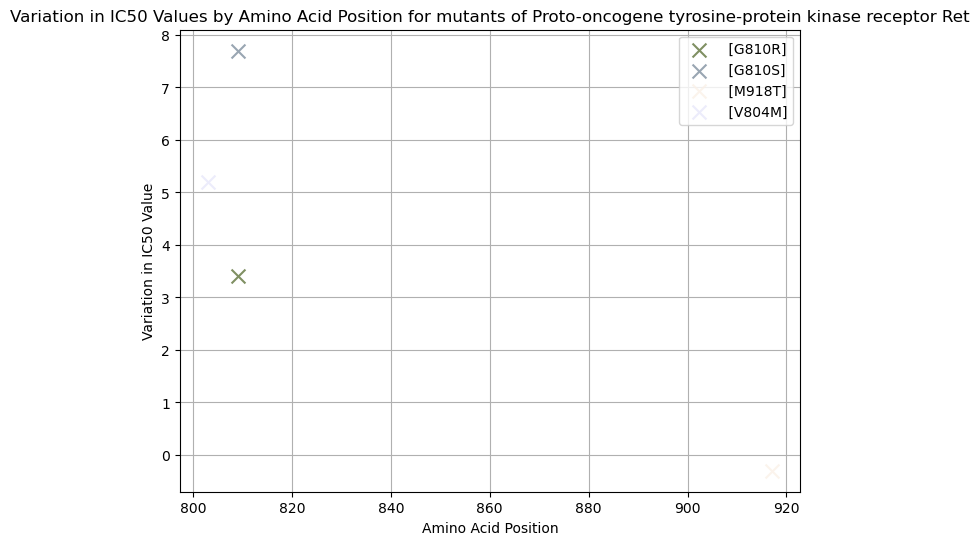

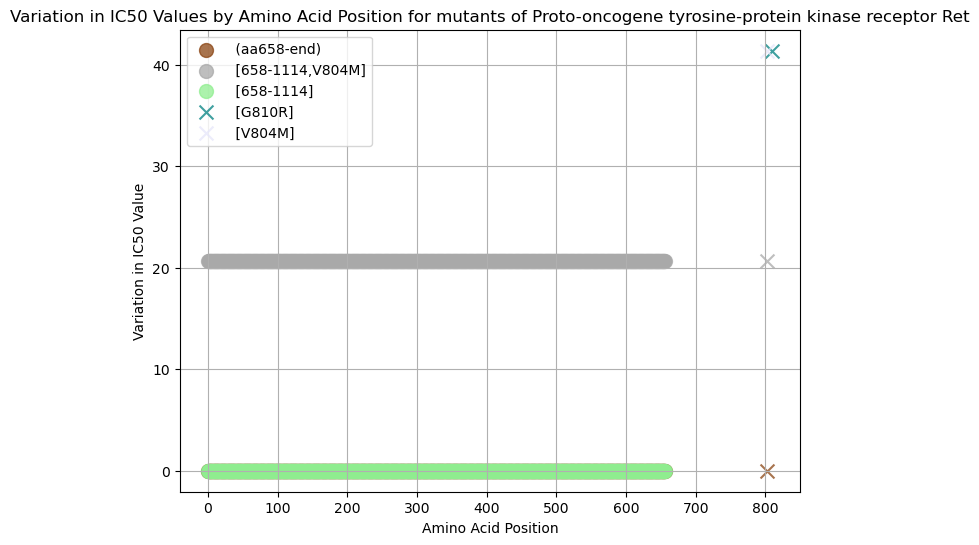

KeyboardInterrupt: 

In [82]:
df_mutants = pd.read_csv('data/mutants.csv')
df_merged = pd.read_csv('data/merged_df.csv')
df_mutants['Target Names'] = df_mutants['Target Names'].apply(lambda x: ast.literal_eval(x))
df_mutants['BindingDB Target Chain Sequence'] = df_mutants['BindingDB Target Chain Sequence'].apply(lambda x: ast.literal_eval(x))

for index, row in df_mutants.iterrows():
    if len(row['Target Names']) > 3:
        df_test = plot_mutants_graph(row, df_merged)
        wt_name = row['WT Target Name']

In [75]:
df_test

,Mutant Name,Positions,Colour,Type,Mutation,IC50,marker
0,Proto-oncogene tyrosine-protein kinase recepto...,0,coral,gap,None,22.6,o
0,Proto-oncogene tyrosine-protein kinase recepto...,1,coral,gap,None,22.6,o
0,Proto-oncogene tyrosine-protein kinase recepto...,2,coral,gap,None,22.6,o
0,Proto-oncogene tyrosine-protein kinase recepto...,3,coral,gap,None,22.6,o
0,Proto-oncogene tyrosine-protein kinase recepto...,4,coral,gap,None,22.6,o
...,...,...,...,...,...,...,...
1,Proto-oncogene tyrosine-protein kinase recepto...,654,darkmagenta,gap,None,0.0,o
1,Proto-oncogene tyrosine-protein kinase recepto...,655,darkmagenta,gap,None,0.0,o
1,Proto-oncogene tyrosine-protein kinase recepto...,656,darkmagenta,gap,None,0.0,o
2,Proto-oncogene tyrosine-protein kinase recepto...,809,indianred,substitution,R -> G,45.2,x
